## 0. Import packages and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import sklearn.preprocessing as pp
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataPath = "/content/drive/MyDrive/ML_final_project"

In [ ]:
train = pd.read_csv(dataPath + "/train.csv")
#test = pd.read_csv(dataPath + "/test.csv")

**Data fields**
- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
killStreaks - Max number of enemy players killed in a short amount of time.
kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [ ]:
train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


In [ ]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%
Memory usage of dataframe is 413.18 MB
Memory usage after optimization is: 121.74 MB
Decreased by 70.5%


In [ ]:
train = train.dropna()
test = test.dropna()

In [ ]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

## 1. EDA

### 1.1 Match Types

In [ ]:
match_types = train['matchType'].value_counts().to_frame().reset_index()
match_types.columns = ["Type","Count"]
match_types['Type'] = match_types['Type'].apply(lambda x: str(x))
match_types

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536761
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


In [ ]:
match_types['Team'] = match_types['Type'].apply(lambda x: 'squad' if ('squad' in x) else ('duo' if ('duo' in x) else ('solo' if ('solo' in x) else 'Unknown')))
match_types['Perspective'] = match_types['Type'].apply(lambda x: 'fpp' if ('fpp' in x) else ('tpp' if ('tpp' in x) else 'Unknown'))
match_types

,Type,Count,Team,Perspective
0,squad-fpp,1756186,squad,fpp
1,duo-fpp,996691,duo,fpp
2,squad,626526,squad,Unknown
3,solo-fpp,536761,solo,fpp
4,duo,313591,duo,Unknown
5,solo,181943,solo,Unknown
6,normal-squad-fpp,17174,squad,fpp
7,crashfpp,6287,Unknown,fpp
8,normal-duo-fpp,5489,duo,fpp
9,flaretpp,2505,Unknown,tpp


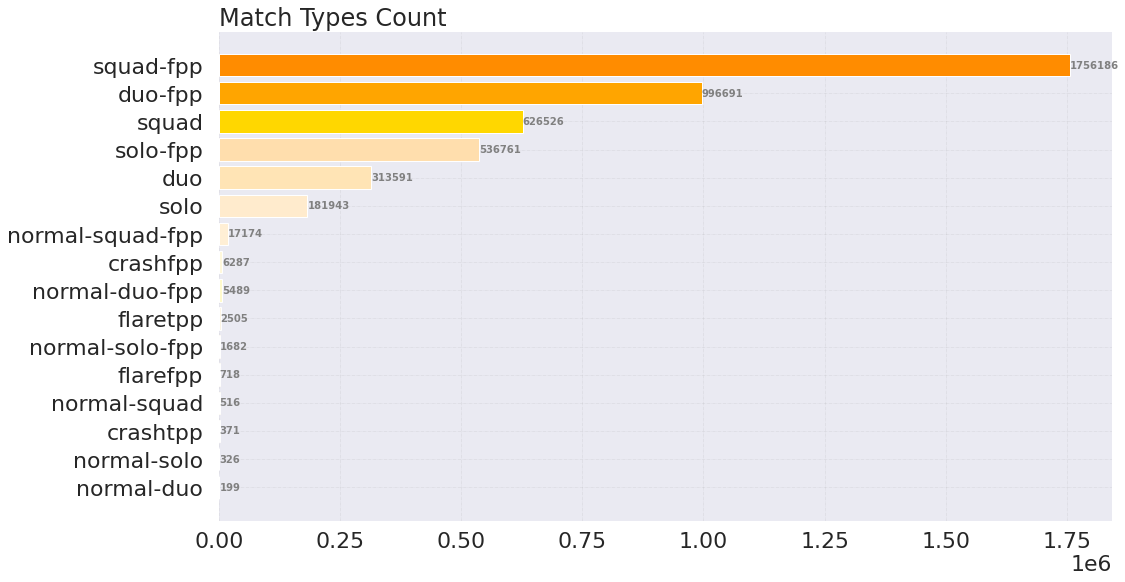

In [ ]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 

colors = ['darkorange', 'orange', 'gold', 'navajowhite', 'moccasin', 
          'blanchedalmond', 'papayawhip', 'cornsilk', 'lemonchiffon', 'oldlace']
# Horizontal Bar Plot
ax.barh(match_types['Type'], match_types['Count'], color = colors)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Match Types Count',
             loc ='left')
 
# Show Plot
plt.show()

In [ ]:
team_count = match_types.groupby(by=['Team']).sum().sort_values(by=['Count'], ascending=False).reset_index()
perspective_count = match_types.groupby(by=['Perspective']).sum().sort_values(by=['Count'], ascending=False).reset_index()

In [ ]:
perspective_count

,Perspective,Count
0,fpp,3320988
1,Unknown,1123101
2,tpp,2876


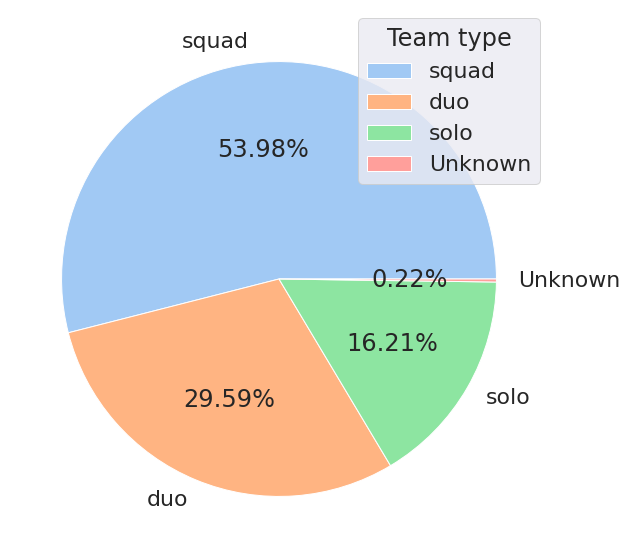

In [ ]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]
sns.set(font_scale=2)
#create pie chart
plt.figure(figsize=(15,10))
plt.pie(team_count['Count'], labels = team_count['Team'], colors = colors, autopct='%.2f%%')
plt.legend(labels=team_count['Team'], title = "Team type")
plt.show()

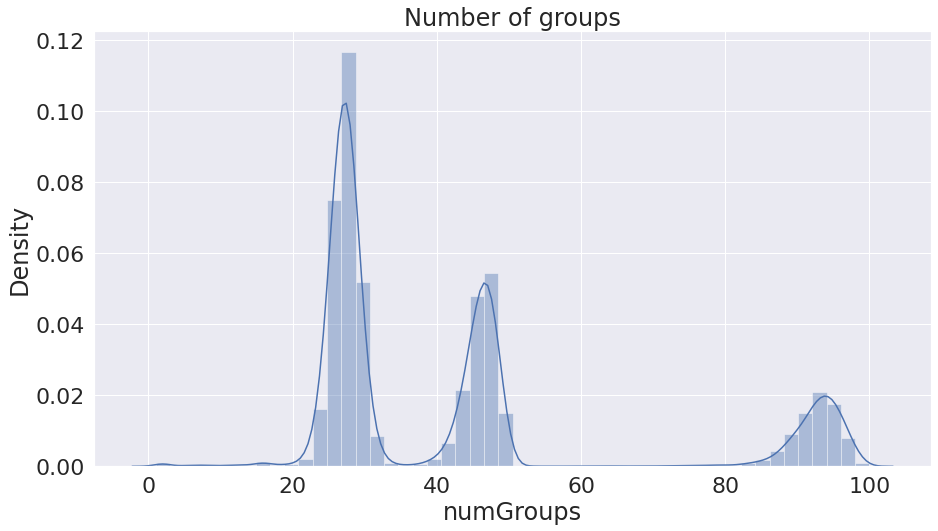

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,8))
ax = sns.distplot(train["numGroups"])
ax.set_title("Number of groups")
plt.show()

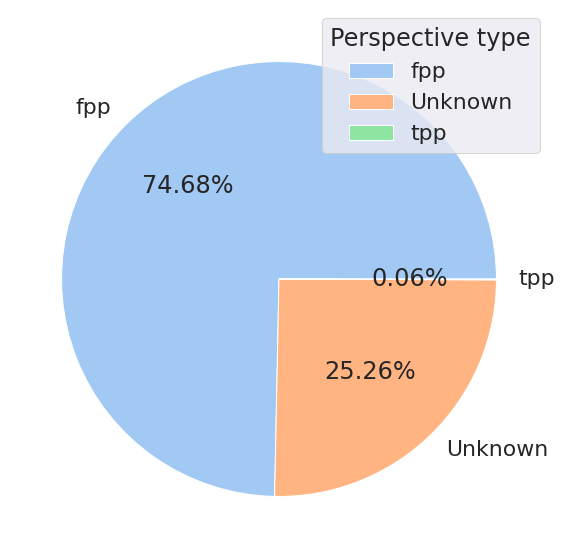

In [ ]:
sns.set(font_scale=2)
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.figure(figsize=(15,10))
plt.pie(perspective_count['Count'], labels = perspective_count['Perspective'], colors = colors, autopct='%.2f%%')
plt.legend(labels=perspective_count['Perspective'], title = "Perspective type")
plt.show()

In [ ]:
train['matchDuration'].groupby(by=train['matchType']).mean()

matchType
crashfpp             892.842691
crashtpp             897.873315
duo                 1646.611606
duo-fpp             1578.642465
flarefpp            1885.945682
flaretpp            1872.002794
normal-duo          1272.507538
normal-duo-fpp      1704.422481
normal-solo         1199.855828
normal-solo-fpp     1008.514863
normal-squad        1315.275194
normal-squad-fpp    1517.550949
solo                1676.379306
solo-fpp            1577.081990
squad               1606.345943
squad-fpp           1552.149803
Name: matchDuration, dtype: float64

In [ ]:
tmp = train[['Id', 'matchDuration', 'matchType']]
tmp['Type'] = tmp['matchType'].apply(lambda x: 'squad' if ('squad' in x) else ('duo' if ('duo' in x) else ('solo' if ('solo' in x) else 'Unknown')))
squad = tmp[tmp['Type'] == 'squad']
duo = tmp[tmp['Type'] == 'duo']
solo = tmp[tmp['Type'] == 'solo']
unknown = tmp[tmp['Type'] == 'Unknown']

In [ ]:
squad

,Id,matchDuration,matchType,Type
0,7f96b2f878858a,1306,squad-fpp,squad
1,eef90569b9d03c,1777,squad-fpp,squad
3,4616d365dd2853,1436,squad-fpp,squad
5,ff79c12f326506,1395,squad-fpp,squad
6,95959be0e21ca3,1316,squad-fpp,squad
...,...,...,...,...
4446956,dae05e0d743059,1693,squad-fpp,squad
4446960,69fa4c2d5431b1,1936,squad-fpp,squad
4446961,afff7f652dbc10,1873,squad-fpp,squad
4446963,e1948b1295c88a,1321,squad-fpp,squad


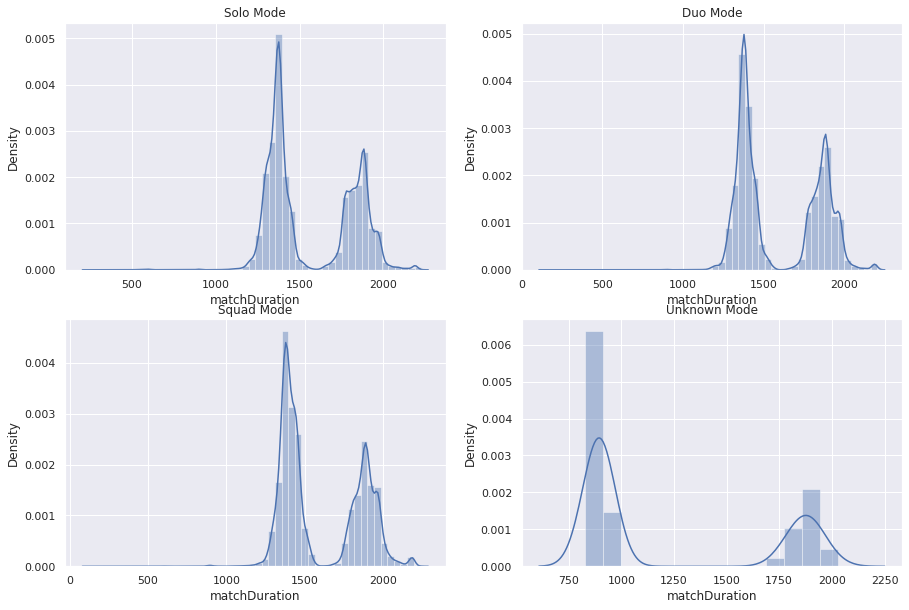

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
fig, axs = plt.subplots(ncols=2, nrows=2)

sns.distplot(squad['matchDuration'], ax=axs[0, 0]).set(title='Solo Mode')
sns.distplot(duo['matchDuration'], ax=axs[0, 1]).set(title='Duo Mode')
sns.distplot(solo['matchDuration'], ax=axs[1, 0]).set(title='Squad Mode')
sns.distplot(unknown['matchDuration'], ax=axs[1, 1]).set(title='Unknown Mode')
#rel.fig.suptitle('Match Duration Distribution')
#plt.title('Match Duration Distribution')
plt.show()

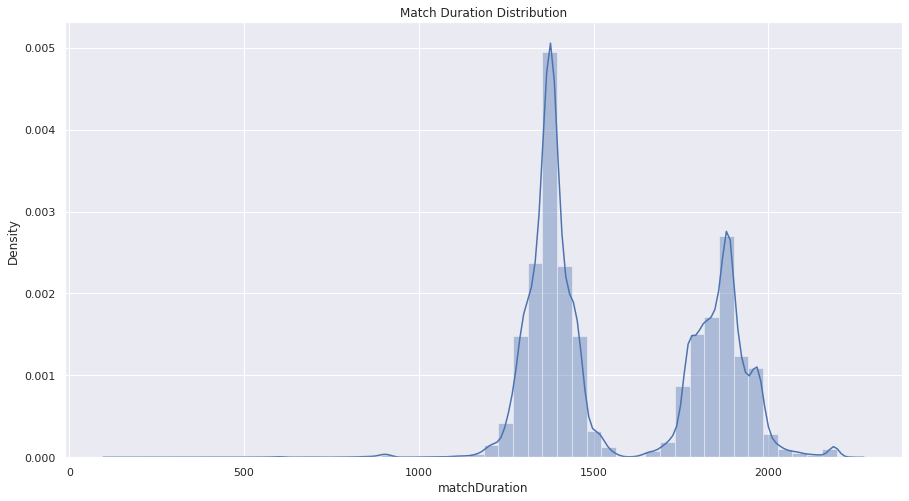

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.distplot(train['matchDuration'])
ax.set_title("Match Duration Distribution")
plt.show()

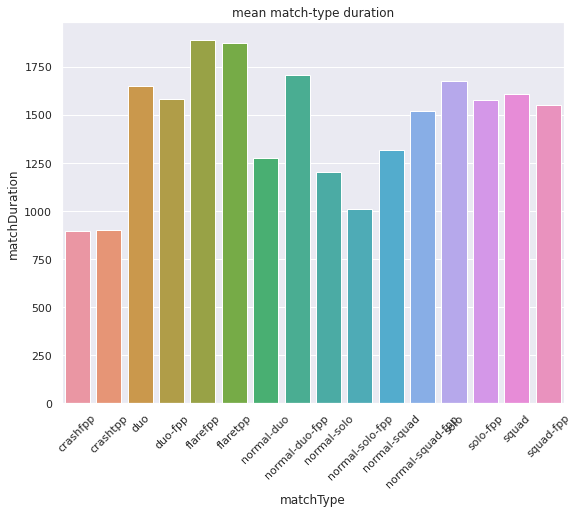

In [ ]:
plt.figure(figsize=(9,7))
match_dur=train.groupby('matchType')['matchDuration'].agg('mean')
sns.barplot(x=match_dur.index,y=match_dur)
plt.gca().set_xticklabels(match_dur.index,rotation='45')
plt.gca().set_title('mean match-type duration')
plt.show()

### 1.2 Player Types

In [ ]:
features = ["Id",'kills','damageDealt','walkDistance','rideDistance','vehicleDestroys','swimDistance','heals', 'boosts', 'assists','DBNOs',"revives","winPlacePerc"]
df_players = train[features]
df_players

,Id,kills,damageDealt,walkDistance,rideDistance,vehicleDestroys,swimDistance,heals,boosts,assists,DBNOs,revives,winPlacePerc
0,7f96b2f878858a,0,0.00000,244.7500,0.000000,0,0.000000,0,0,0,0,0,0.444336
1,eef90569b9d03c,0,91.50000,1434.0000,0.004501,0,11.039062,0,0,0,0,0,0.640137
2,1eaf90ac73de72,0,68.00000,161.7500,0.000000,0,0.000000,0,0,1,0,0,0.775391
3,4616d365dd2853,0,32.90625,202.7500,0.000000,0,0.000000,0,0,0,0,0,0.166748
4,315c96c26c9aac,1,100.00000,49.7500,0.000000,0,0.000000,0,0,0,0,0,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,0,0.00000,1019.0000,1292.000000,0,0.000000,0,0,0,0,0,0.178589
4446962,f4197cf374e6c0,0,44.15625,81.6875,0.000000,0,0.000000,0,1,0,0,0,0.293457
4446963,e1948b1295c88a,0,59.06250,788.5000,0.000000,0,2.183594,0,0,0,0,0,0.481445
4446964,cc032cdd73b7ac,2,180.37500,2748.0000,0.000000,0,0.000000,2,4,0,1,2,0.799805


In [ ]:
df_players.dtypes

Id                  object
kills                 int8
damageDealt        float16
walkDistance       float16
rideDistance       float16
vehicleDestroys       int8
swimDistance       float16
heals                 int8
boosts                int8
assists               int8
DBNOs                 int8
revives               int8
winPlacePerc       float16
dtype: object

In [ ]:
X = df_players.drop(columns = ["Id","winPlacePerc"])
sc = pp.StandardScaler()
X_sc = sc.fit_transform(X)
X_sc.shape

(4446965, 11)

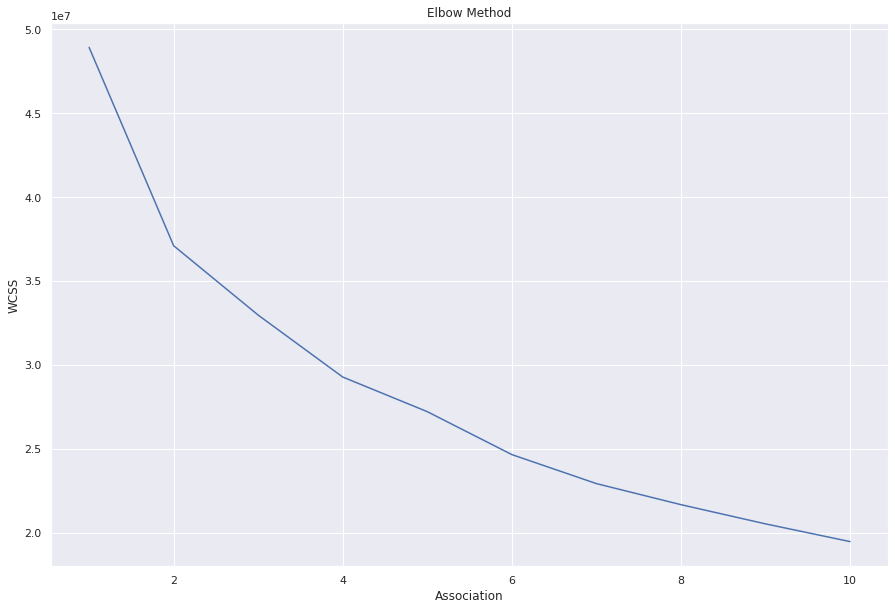

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(X_sc)
    wcss.append(kmeans.inertia_)
  
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state = 18)
model = kmeans.fit(X)
clusters = model.predict(X)
df_players["Cluster"] = clusters 

In [ ]:
df_players

,Id,kills,damageDealt,walkDistance,rideDistance,vehicleDestroys,swimDistance,heals,boosts,assists,DBNOs,revives,winPlacePerc,Cluster
0,7f96b2f878858a,0,0.00000,244.7500,0.000000,0,0.000000,0,0,0,0,0,0.444336,2
1,eef90569b9d03c,0,91.50000,1434.0000,0.004501,0,11.039062,0,0,0,0,0,0.640137,0
2,1eaf90ac73de72,0,68.00000,161.7500,0.000000,0,0.000000,0,0,1,0,0,0.775391,2
3,4616d365dd2853,0,32.90625,202.7500,0.000000,0,0.000000,0,0,0,0,0,0.166748,2
4,315c96c26c9aac,1,100.00000,49.7500,0.000000,0,0.000000,0,0,0,0,0,0.187500,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,0,0.00000,1019.0000,1292.000000,0,0.000000,0,0,0,0,0,0.178589,0
4446962,f4197cf374e6c0,0,44.15625,81.6875,0.000000,0,0.000000,0,1,0,0,0,0.293457,2
4446963,e1948b1295c88a,0,59.06250,788.5000,0.000000,0,2.183594,0,0,0,0,0,0.481445,2
4446964,cc032cdd73b7ac,2,180.37500,2748.0000,0.000000,0,0.000000,2,4,0,1,2,0.799805,4


Text(0, 0.5, 'Ride Distance')

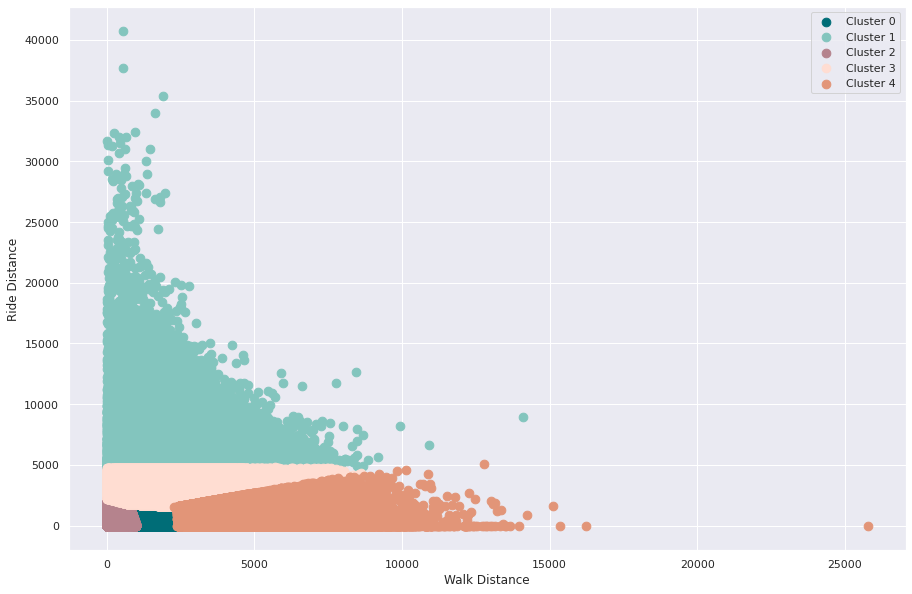

In [ ]:
col = ["#006D77", "#83C5BE","#B5838D","#FFDDD2","#E29578"]
for i in range(5):
  plt.scatter(df_players[df_players["Cluster"] == i]["walkDistance"], df_players[df_players["Cluster"] == i]["rideDistance"], s = 75, c= col[i])

plt.legend(labels=["Cluster 0","Cluster 1","Cluster 2","Cluster 3","Cluster 4"])
plt.xlabel('Walk Distance')
plt.ylabel('Ride Distance')

Text(0, 0.5, 'Damage Dealt')

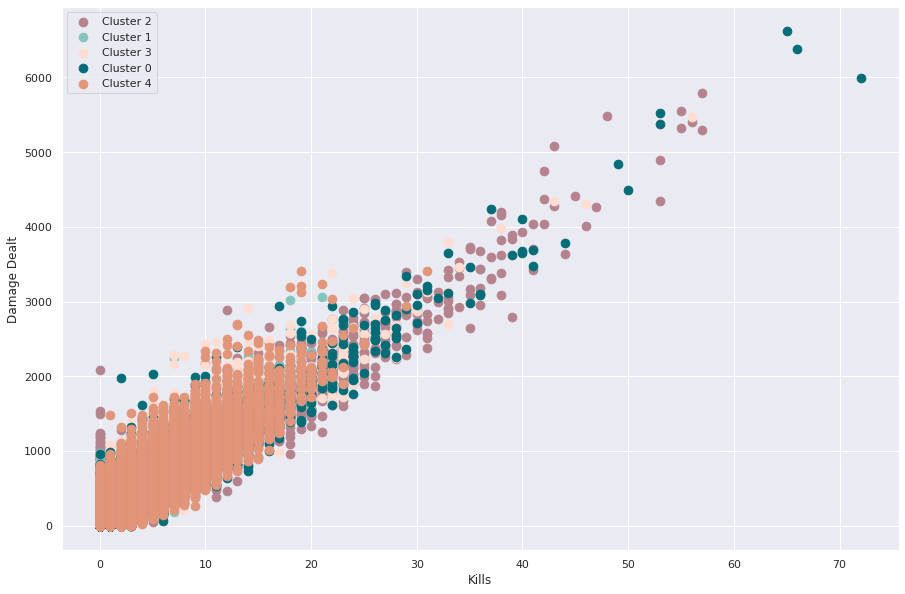

In [ ]:
col = ["#006D77", "#83C5BE","#B5838D","#FFDDD2","#E29578"]
for i in (2,1,3,0,4):
  plt.scatter(df_players[df_players["Cluster"] == i]["kills"], df_players[df_players["Cluster"] == i]["damageDealt"], s = 75, c= col[i])

plt.legend(labels=["Cluster 2","Cluster 1","Cluster 3","Cluster 0","Cluster 4"])
plt.xlabel('Kills')
plt.ylabel('Damage Dealt')

Text(0, 0.5, 'Heals')

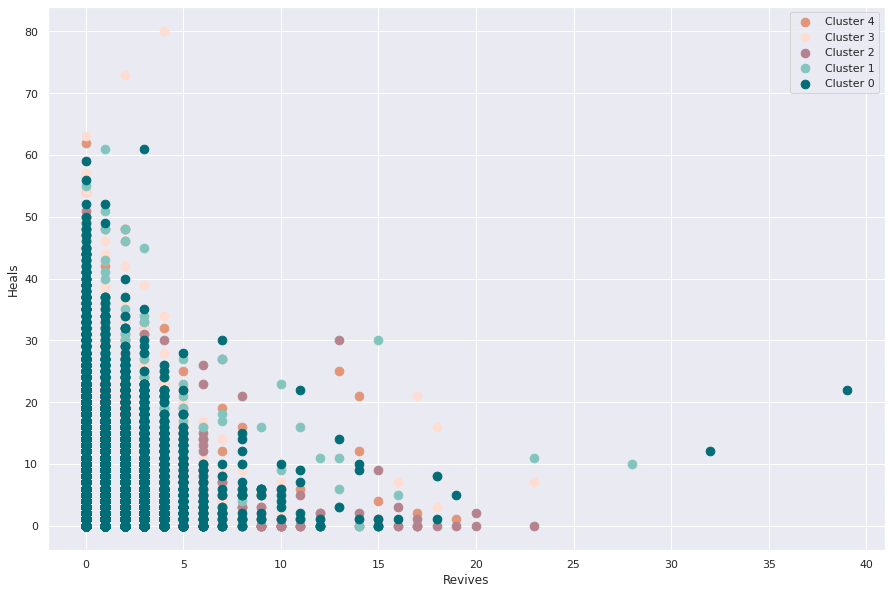

In [ ]:
col = ["#006D77", "#83C5BE","#B5838D","#FFDDD2","#E29578"]
for i in (4,3,2,1,0):
  plt.scatter(df_players[df_players["Cluster"] == i]["revives"], df_players[df_players["Cluster"] == i]["heals"], s = 75, c= col[i])

plt.legend(labels=["Cluster 4","Cluster 3","Cluster 2","Cluster 1","Cluster 0"])
plt.xlabel('Revives')
plt.ylabel('Heals')

In [ ]:
g = df_players.groupby('Cluster').mean()
g.iloc[0:5,0:5]

,kills,damageDealt,walkDistance,rideDistance,vehicleDestroys
Cluster,,,,,
0,1.151863,157.000,1672.00,233.625000,0.006766
1,1.383413,195.875,2038.00,6508.000000,0.044361
2,0.477981,78.250,263.75,30.046875,0.000975
3,1.366838,189.500,2058.00,3034.000000,0.031339
4,2.033357,253.375,3252.00,302.750000,0.012705


In [ ]:
g.iloc[0:5,5:12]

,swimDistance,heals,boosts,assists,DBNOs,revives,winPlacePerc
Cluster,,,,,,,
0,7.183594,1.746749,1.463422,0.272387,0.753113,0.211272,0.663086
1,8.093750,3.839621,2.821468,0.419762,0.980256,0.309978,0.772949
2,0.601562,0.405696,0.224652,0.106531,0.413633,0.074350,0.253906
3,8.007812,3.091570,2.331698,0.383318,0.939258,0.288037,0.711426
4,13.492188,2.989216,2.968047,0.559003,1.261643,0.348874,0.853516


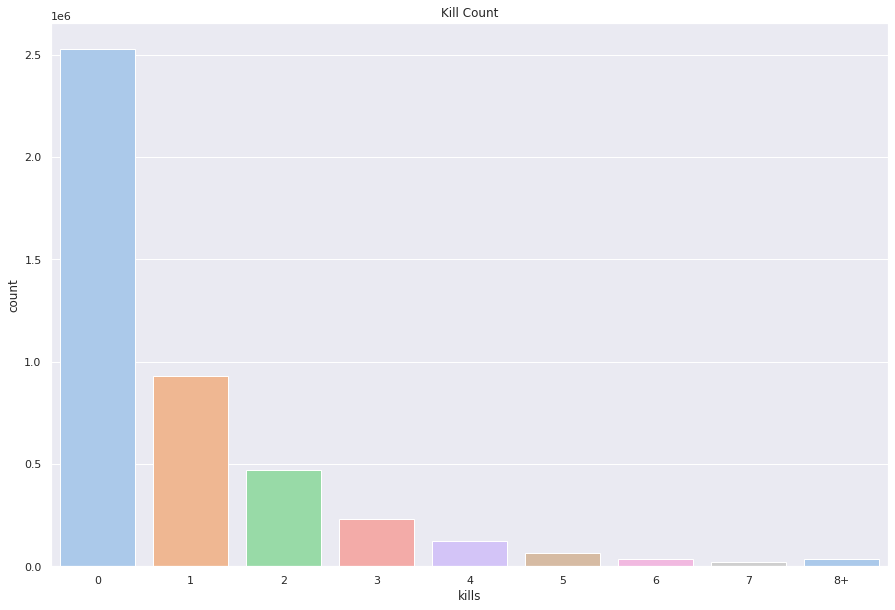

In [ ]:
#colors = ['darkorange', 'orange', 'gold', 'navajowhite', 'moccasin', 
          #'blanchedalmond', 'papayawhip', 'cornsilk', 'lemonchiffon', 'oldlace']
data = train.copy()
data.loc[data['kills'] > 7] = '8+'
sns.countplot(data['kills'].astype('str').sort_values(), palette = sns.color_palette('pastel')[0:8])
plt.title("Kill Count")
plt.show()

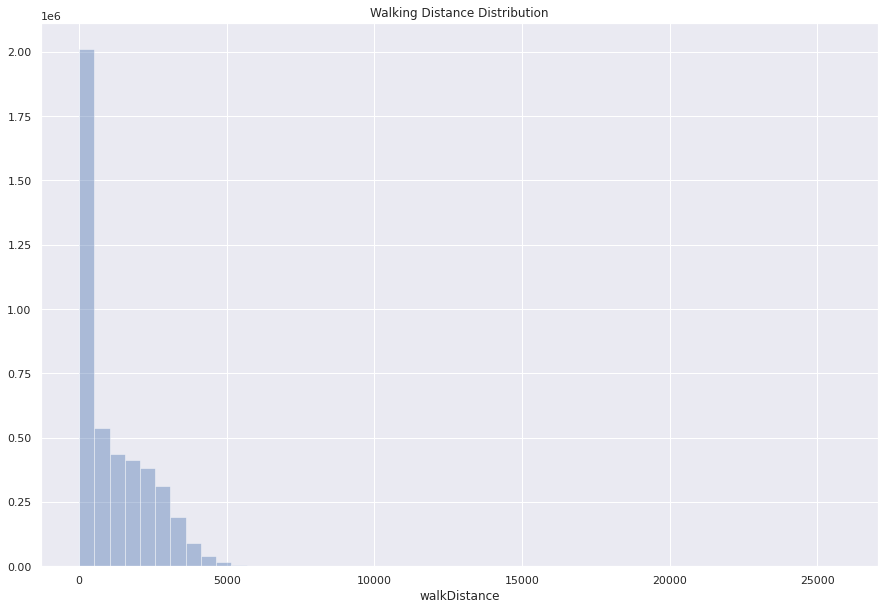

In [ ]:
#plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution")
sns.distplot(train['walkDistance'],kde=False)
plt.show()

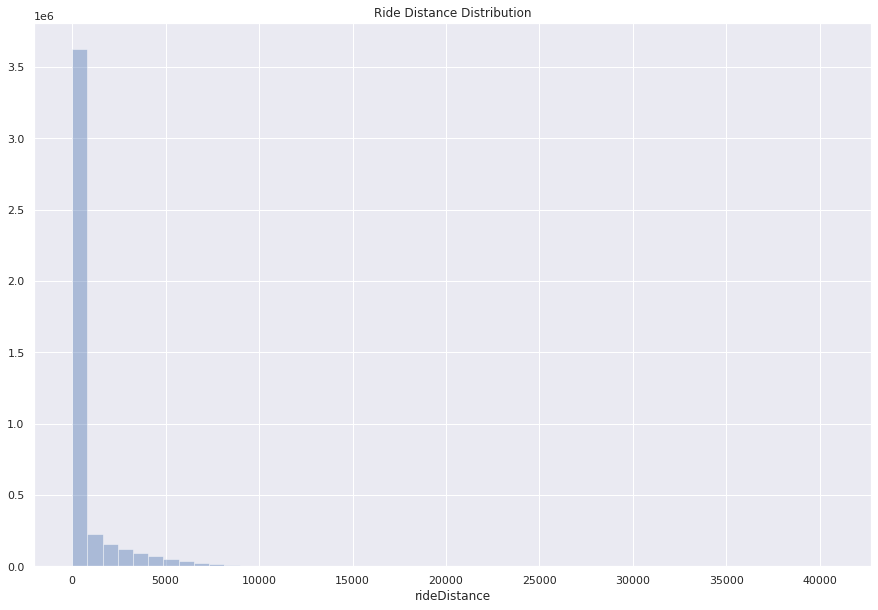

In [ ]:
#plt.figure(figsize=(15,10))
plt.title("Ride Distance Distribution")
sns.distplot(train['rideDistance'],kde=False)
plt.show()

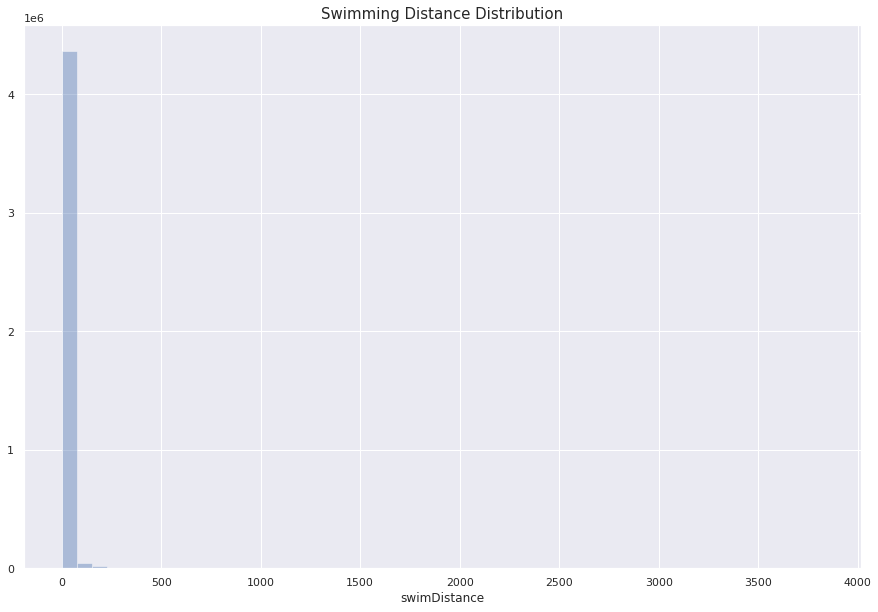

In [ ]:
data = train.copy()
#plt.figure(figsize=(15,10))
plt.title("Swimming Distance Distribution",fontsize=15)
sns.distplot(data['swimDistance'],kde=False)
plt.show()

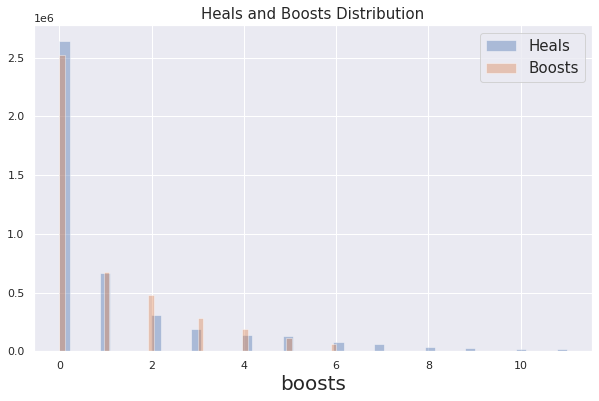

In [ ]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Heals and Boosts Distribution",fontsize=15)
sns.distplot(data['heals'], ax = ax, kde=False)
sns.distplot(data['boosts'], ax = ax, kde=False)
plt.legend(labels=["Heals","Boosts"],fontsize=15)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.show()

## 2. Data preprocessing

### 2.1 Remove outliers

In [11]:
# add total_distance column
train['total_distance']=train.rideDistance + train.walkDistance + train.swimDistance
test['total_distance']=test.rideDistance + test.walkDistance + test.swimDistance

#### Kills outliers

In [12]:
# kills_without_moving
#train
train['kills_without_moving']=((train['kills']>0)&(train['total_distance']==0))
#test
test['kills_without_moving']=((test['kills']>0)&(test['total_distance']==0))

In [13]:
train['kills_without_moving'].value_counts()

False    4445430
True        1535
Name: kills_without_moving, dtype: int64

In [14]:
test['kills_without_moving'].value_counts()

False    1933863
True         311
Name: kills_without_moving, dtype: int64

In [15]:
train.drop(train[train['kills_without_moving']==True].index,inplace=True)
test.drop(test[test['kills_without_moving']==True].index,inplace=True)

In [16]:
# kills count
train['kills'].value_counts()
#test
test['kills'].value_counts()

0     1099421
1      404819
2      206319
3      101149
4       54100
5       28877
6       16468
7        9262
8        5278
9        3281
10       1902
11       1156
12        674
13        417
14        230
15        151
16        119
17         71
18         37
19         33
20         21
22         11
30         11
21          8
24          8
23          5
25          5
26          4
31          3
28          3
37          2
33          2
36          2
32          2
27          1
47          1
34          1
56          1
40          1
29          1
58          1
46          1
55          1
52          1
41          1
43          1
Name: kills, dtype: int64

In [17]:
train.drop(train[train['kills']>=35].index,inplace=True)
test.drop(test[test['kills']>=35].index,inplace=True)

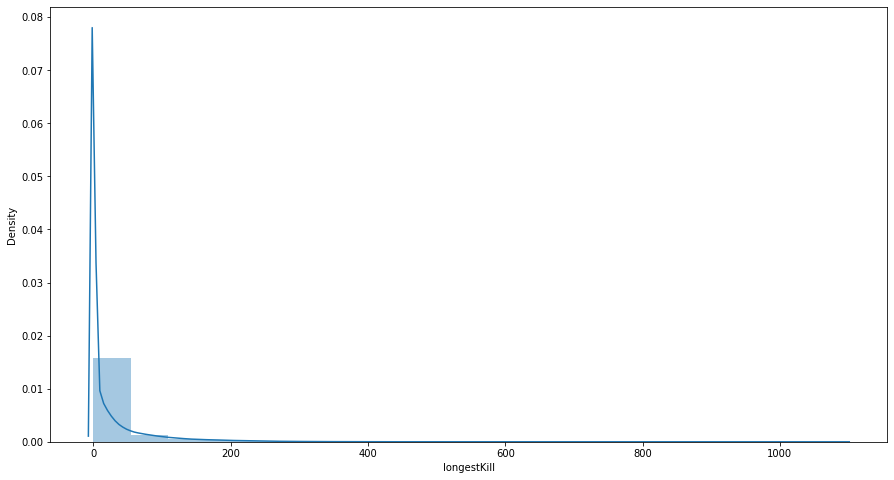

In [ ]:
# Longest kills
plt.subplots(figsize=(15,8))
sns.distplot(train['longestKill'],bins=20)

In [18]:
train.drop(train[train['longestKill']>=1000].index,inplace=True)
test.drop(test[test['longestKill']>=1000].index,inplace=True)

#### Travelling outliers

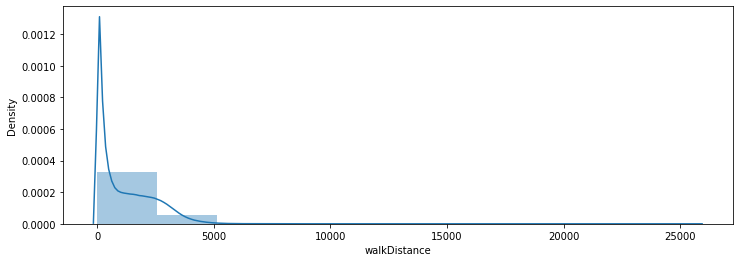

In [ ]:
# plot walkDistance 
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()

In [19]:
train.drop(train[train['walkDistance']>=10000].index,inplace=True)
test.drop(test[test['walkDistance']>=10000].index,inplace=True)

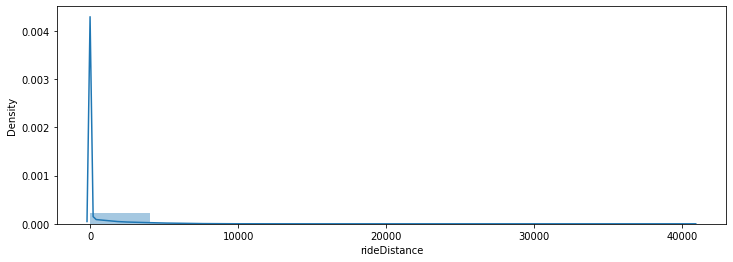

In [ ]:
# plot rideDistance
plt.subplots(figsize=(12,4))
sns.distplot(train.rideDistance,bins=10)
plt.show()

In [20]:
train.drop(train[train.rideDistance >=15000].index, inplace=True)
test.drop(test[test.rideDistance >=15000].index, inplace=True)

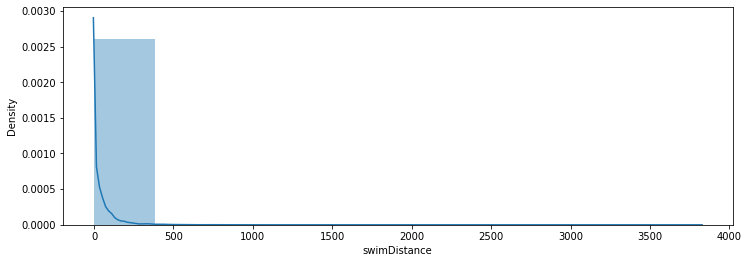

In [ ]:
# swimDistance
plt.subplots(figsize=(12, 4))
sns.distplot(train.swimDistance,bins=10)

In [21]:
train.drop(train[train.swimDistance>=1000].index,inplace=True)
test.drop(test[test.swimDistance>=1000].index,inplace=True)

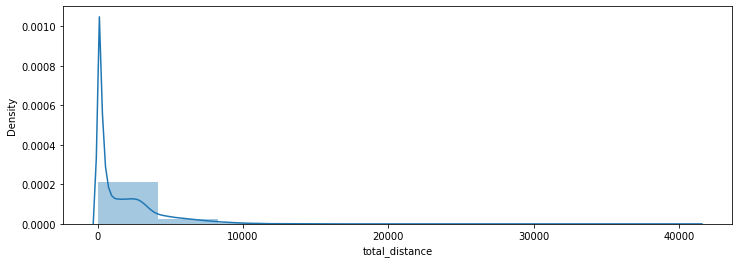

In [ ]:
# total_distance
plt.subplots(figsize=(12,4))
sns.distplot(train.total_distance,bins=10)

In [22]:
train.drop(train[train.total_distance>=15000].index,inplace=True)
test.drop(test[test.total_distance>=15000].index,inplace=True)

#### Weapons

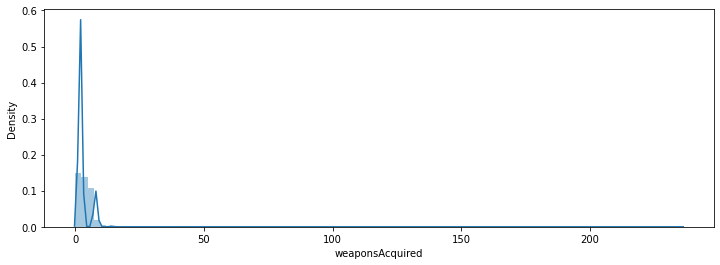

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [23]:
train.drop(train[train.weaponsAcquired>=50].index,inplace=True)
test.drop(test[test.weaponsAcquired>=50].index,inplace=True)

#### Heals

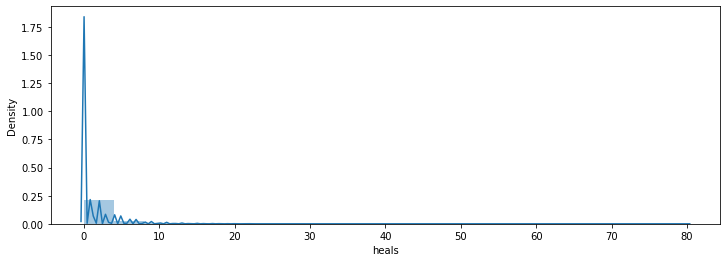

In [ ]:
plt.subplots(figsize=(12,4))
sns.distplot(train.heals, bins=20)

In [24]:
train.drop(train[train.heals>=40].index,inplace=True)
test.drop(test[test.heals>=40].index,inplace=True)

### 2.2 feature engineering

In [25]:
# Normalise the matchTypes to standard fromat
def standardize_matchType(data):
    data['matchType'][data['matchType'] == 'normal-solo'] = 'Solo'
    data['matchType'][data['matchType'] == 'solo-fpp'] = 'Solo'
    data['matchType'][data['matchType'] == 'normal-solo-fpp'] = 'Solo'
    data['matchType'][data['matchType'] == 'normal-duo-fpp'] = 'Duo'
    data['matchType'][data['matchType'] == 'normal-duo'] = 'Duo'
    data['matchType'][data['matchType'] == 'duo-fpp'] = 'Duo'
    data['matchType'][data['matchType'] == 'squad-fpp'] = 'Squad'
    data['matchType'][data['matchType'] == 'normal-squad'] = 'Squad'
    data['matchType'][data['matchType'] == 'normal-squad-fpp'] = 'Squad'
    data['matchType'][data['matchType'] == 'flaretpp'] = 'Other'
    data['matchType'][data['matchType'] == 'flarefpp'] = 'Other'
    data['matchType'][data['matchType'] == 'crashtpp'] = 'Other'
    data['matchType'][data['matchType'] == 'crashfpp'] = 'Other'

    return data


train = standardize_matchType(train)

In [27]:
train['health_items'] = train['heals'] + train['boosts']
train['headhshot_perc'] = train['headshotKills'] / train['kills']
train['headhshot_perc'] = train['headhshot_perc'].fillna(0)
train['teamwork'] = train['assists'] + train['revives']
train['killStreak_len'] = train['killStreaks']/train['kills']
train['killStreak_len'] = train['killStreak_len'].fillna(0)
train['totalHits'] = train['DBNOs'] + train['kills'] + train['teamKills']

In [28]:
train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,weaponsAcquired,winPoints,winPlacePerc,total_distance,kills_without_moving,health_items,headhshot_perc,teamwork,killStreak_len,totalHits
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,1,1466,0.444336,244.7500,False,0,0.0,0,0.0,0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,5,0,0.640137,1445.0000,False,0,0.0,0,0.0,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,2,0,0.775391,161.7500,False,0,0.0,1,0.0,0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,3,0,0.166748,202.7500,False,0,0.0,0,0.0,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,2,0,0.187500,49.7500,False,0,0.0,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,...,3,1507,0.178589,2312.0000,False,0,0.0,0,0.0,0
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15625,0,0,0,69,...,6,0,0.293457,81.6875,False,1,0.0,0,0.0,0
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06250,0,0,0,66,...,4,0,0.481445,790.5000,False,0,0.0,0,0.0,0
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.37500,1,1,2,11,...,8,0,0.799805,2748.0000,False,6,0.5,2,0.5,3


In [ ]:
#combining the item uses that replenish health into a single column
def health_items(df):
    df['health_items'] = df['heals'] + df['boosts']
    return df

#calculating the headshot ratio
def headhshot_perc(df):
    df['headhshot_perc'] = df['headshotKills'] / df['kills']
    df['headhshot_perc'] = df['headhshot_perc'].fillna(0)
    return df

# adding the elements that indicate teamwork
def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

#calculates the average length of a kill streak
def killStreak_len(df):
    df['killStreak_len']=df['killStreaks']/df['kills']
    df['killStreak_len']=df['killStreak_len'].fillna(0)
    return df
    
#sum of the knockouts kills and teamkills
def total_hits(df):
    df['totalHits'] = train['DBNOs'] + train['kills'] + train['teamKills']
    return df

In [29]:
train = train.drop(columns={'Id', 'groupId', 'matchId', 'kills_without_moving'})

In [30]:
train

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,walkDistance,weaponsAcquired,winPoints,winPlacePerc,total_distance,health_items,headhshot_perc,teamwork,killStreak_len,totalHits
0,0,0,0.00000,0,0,0,60,1241,0,0,...,244.7500,1,1466,0.444336,244.7500,0,0.0,0,0.0,0
1,0,0,91.50000,0,0,0,57,0,0,0,...,1434.0000,5,0,0.640137,1445.0000,0,0.0,0,0.0,0
2,1,0,68.00000,0,0,0,47,0,0,0,...,161.7500,2,0,0.775391,161.7500,0,0.0,1,0.0,0
3,0,0,32.90625,0,0,0,75,0,0,0,...,202.7500,3,0,0.166748,202.7500,0,0.0,0,0.0,0
4,0,0,100.00000,0,0,0,45,0,1,1,...,49.7500,2,0,0.187500,49.7500,0,0.0,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,0,0,0.00000,0,0,0,74,1029,0,0,...,1019.0000,3,1507,0.178589,2312.0000,0,0.0,0,0.0,0
4446962,0,1,44.15625,0,0,0,69,0,0,0,...,81.6875,6,0,0.293457,81.6875,1,0.0,0,0.0,0
4446963,0,0,59.06250,0,0,0,66,0,0,0,...,788.5000,4,0,0.481445,790.5000,0,0.0,0,0.0,0
4446964,0,4,180.37500,1,1,2,11,0,2,1,...,2748.0000,8,0,0.799805,2748.0000,6,0.5,2,0.5,3


In [32]:
train.to_pickle(dataPath+'/train_clean.pkl')

### 2.3 Feature selection

In [6]:
train = pd.read_pickle(dataPath + "/train_clean.pkl")

In [7]:
numerical_cols = list(train.columns)
numerical_cols.remove('matchType')
numerical_cols.remove('winPlacePerc')

In [8]:
# numerical_cols = ['assists', 'boosts', 'damageDealt', 'DBNOs',
#                   'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
#                   'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
#                   'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 
#                   'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
#                   'weaponsAcquired', 'winPoints']

cat_cols = ['matchType']

In [9]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=5)

In [10]:
train_inputs = train_df.drop(columns=['winPlacePerc'])
y_train = train_df['winPlacePerc']
valid_inputs = val_df.drop(columns=['winPlacePerc'])
y_valid = val_df['winPlacePerc']

In [11]:
from sklearn.preprocessing import StandardScaler

#creating instance of a StandardScaler
scaler = StandardScaler().fit(train_inputs[numerical_cols])

In [12]:
#scaling the numeric features
train_inputs[numerical_cols] = scaler.transform(train_inputs[numerical_cols])
valid_inputs[numerical_cols] = scaler.transform(valid_inputs[numerical_cols])

In [13]:
from sklearn.preprocessing import OneHotEncoder
#encoding categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_inputs[cat_cols])
category_cols = list(encoder.get_feature_names(cat_cols))
train_inputs[category_cols] = encoder.transform(train_inputs[cat_cols])

In [14]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(valid_inputs[cat_cols])
category_cols = list(encoder.get_feature_names(cat_cols))
valid_inputs[category_cols] = encoder.transform(valid_inputs[cat_cols])

In [59]:
train_inputs.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'total_distance', 'health_items', 'headhshot_perc', 'teamwork',
       'killStreak_len', 'totalHits', 'matchType_Duo', 'matchType_Other',
       'matchType_Solo', 'matchType_Squad', 'matchType_duo', 'matchType_solo',
       'matchType_squad'],
      dtype='object')

In [15]:
#including both columns to get the dataframe that we can put through the model
X_train = train_inputs[numerical_cols + category_cols]
X_valid = valid_inputs[numerical_cols + category_cols]

In [57]:
X_train

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,teamwork,killStreak_len,totalHits,matchType_Duo,matchType_Other,matchType_Solo,matchType_Squad,matchType_duo,matchType_solo,matchType_squad
165615,1.311861,-0.062201,-0.771069,-0.575486,-0.379926,-0.513225,-0.350244,-0.804723,-0.598621,-0.765099,...,0.733713,-0.777122,-0.641073,0.0,0.0,0.0,1.0,0.0,0.0,0.0
475594,1.311861,-0.645080,-0.473515,-0.575486,-0.379926,-0.513225,1.251814,0.980080,-0.598621,-0.765099,...,0.733713,-0.777122,-0.641073,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1096343,-0.398381,1.103557,0.629101,0.300495,-0.379926,0.988404,-1.005631,1.274892,0.050994,0.643195,...,-0.484036,1.598477,0.159140,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2787308,-0.398381,4.017951,-0.771069,-0.575486,-0.379926,0.988404,-0.058961,-0.804723,-0.598621,-0.765099,...,-0.484036,-0.777122,-0.641073,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3233834,1.311861,1.103557,1.270784,1.176476,-0.379926,3.991662,-1.296915,-0.804723,0.700609,0.643195,...,1.951463,0.410677,0.959353,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558487,1.311861,0.520678,0.204762,-0.575486,-0.379926,-0.137817,-0.168192,-0.804723,-0.598621,-0.765099,...,0.733713,-0.777122,-0.641073,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3994552,-0.398381,-0.645080,-0.771069,-0.575486,-0.379926,-0.513225,1.688739,1.352977,-0.598621,-0.765099,...,-0.484036,-0.777122,-0.641073,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2760102,-0.398381,1.686436,-0.771069,-0.575486,-0.379926,-0.513225,0.123091,1.070914,-0.598621,-0.765099,...,-0.484036,-0.777122,-0.641073,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1958448,-0.398381,-0.645080,-0.609632,-0.575486,-0.379926,-0.513225,1.251814,1.195213,-0.598621,-0.765099,...,-0.484036,-0.777122,-0.641073,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 3. Fit models

- linear regression
- decision tree
- random forest
- XGBoost
- LightGBM 

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### 3.1 Linear Regression - baseline

In [64]:
from sklearn.linear_model import LinearRegression
lg = LinearRegression()
lg.fit(X_train, y_train)
y_pred_train_lg = lg.predict(X_train)
y_pred_valid_lg = lg.predict(X_valid)

In [65]:
lg_train_mae = mean_absolute_error(y_train, y_pred_train_lg)
lg_valid_mae = mean_absolute_error(y_valid, y_pred_valid_lg)
print("Training Mean Absolute Error: ", lg_train_mae)
print("Validation Mean Absolute Error: ", lg_valid_mae)

Training Mean Absolute Error:  0.08645197008859351
Validation Mean Absolute Error:  0.08662200560086118


In [67]:
lg_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_lg))
lg_valid_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid_lg))
print("Training Mean Absolute Error: ", lg_train_rmse)
print("Validation Mean Absolute Error: ", lg_valid_rmse)

Training Mean Absolute Error:  0.11865604981064642
Validation Mean Absolute Error:  0.11895565734526958


### 3.2 LightGBM

In [16]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from lightgbm import LGBMRegressor

In [17]:
lgbm = LGBMRegressor(random_state=5, n_jobs=-1)
lgbm.fit(X_train, y_train)
y_pred_train_lgbm = lgbm.predict(X_train)
y_pred_valid_lgbm = lgbm.predict(X_valid)

In [18]:
lgbm_train_mae = mean_absolute_error(y_train, y_pred_train_lgbm)
lgbm_valid_mae = mean_absolute_error(y_valid, y_pred_valid_lgbm)
print("Training Mean Absolute Error: ", lgbm_train_mae)
print("Validation Mean Absolute Error: ", lgbm_valid_mae)

Training Mean Absolute Error:  0.05943546812333548
Validation Mean Absolute Error:  0.05957802119479273


In [ ]:
parameters = {
    'task' : ['predict'],
    'boosting': ['gbdt'],
    'objective': ['root_mean_squared_error'],
    'num_iterations': [500, 1000, 1500],
    'learning_rate':[0.05, 0.005],
   'num_leaves':[5, 10, 15],
   'max_depth' :[10,15,20],
  'feature_fraction': [0.6, 0.8],
    'bagging_fraction': [0.6, 0.8],
    'bagging_freq': [100, 200, 400],
}

lgb_model = LGBMRegressor()
gsearch_lgb = GridSearchCV(lgb_model, param_grid = parameters, n_jobs=6, cv = 5, verbose=10)
gsearch_lgb.fit(X_train,y_train)

In [ ]:
preds_lgb_model = gsearch_lgb.predict(X_valid)
rmse_lgb = np.sqrt(mean_squared_error(y_valid, preds_lgb_model))
print(" RMSE: %f" % (rmse_lgb))